In [25]:
!pip install datasets

In [26]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [27]:
from datasets import load_dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "malayalam")

print(dataset)

train-00000-of-00001.parquet:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1999 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16010
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1999
    })
})


In [28]:
from datasets import load_dataset
import re
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "malayalam")

# Convert the dataset to a list of dictionaries so train_test_split can be applied
train_data = dataset['train']

# Convert the dataset to a list of dicts (this step should be done carefully)
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split the train data into 90% for training and 10% for testing
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Clean function to preserve emojis and emoticons
def clean_text(text):
    # Remove unwanted characters but keep emojis and emoticons
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    # Keep only letters, numbers, whitespaces, and emojis
    text = re.sub(r'[^a-zA-Z0-9\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251]', '', text)
    text = text.strip()
    return text

# Apply the cleaning function to the train, test, and validation datasets
train_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in train_data_split]
test_data_split = [{'text': clean_text(item['text']), 'label': item['label']} for item in test_data_split]
dataset['validation'] = [{'text': clean_text(item['text']), 'label': item['label']} for item in dataset['validation']]

# Check the cleaned data
print(train_data_split[1])
print(test_data_split[0])
print(dataset['validation'][0])

{'text': 'Waiting for mass but 2', 'label': 0}
{'text': 'Padam onnu eragikotteda pahayanmare appalekum chelakkan kuthirikunu ororthanmaru Onnu poyinada', 'label': 0}
{'text': 'Gopichettante BGM um mammookayum ishtapedunnavar like', 'label': 0}


In [30]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("community-datasets/offenseval_dravidian", "malayalam")

# Extract train data
train_data = dataset['train']

# Convert to a list of dictionaries for train_test_split
train_data_list = [{'text': item['text'], 'label': item['label']} for item in train_data]

# Split train data into 90% train and 10% test
train_data_split, test_data_split = train_test_split(train_data_list, test_size=0.1, random_state=42)

# Convert lists of dictionaries to pandas DataFrames
df_train = pd.DataFrame(train_data_split)
df_test = pd.DataFrame(test_data_split)
df_val = pd.DataFrame([{'text': item['text'], 'label': item['label']} for item in dataset['validation']])

# Ensure the DataFrames contain the required columns
required_columns = ['text', 'label']
for df_name, df in zip(['df_train', 'df_test', 'df_val'], [df_train, df_test, df_val]):
    if not all(col in df.columns for col in required_columns):
        raise KeyError(f"{df_name} must contain the columns {required_columns}.")

# Function to extract emojis from the text
def extract_emojis(text):
    emoji_pattern = re.compile(
        r'[\U0001F600-\U0001F64F'  # emoticons
        r'\U0001F300-\U0001F5FF'  # symbols & pictographs
        r'\U0001F680-\U0001F6FF'  # transport & map symbols
        r'\U0001F700-\U0001F77F'  # alchemical symbols
        r'\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        r'\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        r'\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        r'\U0001FA00-\U0001FA6F'  # Chess Symbols
        r'\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        r'\U00002702-\U000027B0'  # Dingbats
        r'\U000024C2-\U0001F251'  # Enclosed characters
        r']+', flags=re.UNICODE)
    emojis = emoji_pattern.findall(text)
    return ''.join(emojis)

# Function to separate emojis and clean text
def separate_emojis(text):
    emojis = extract_emojis(text)
    # Remove emojis and keep only cleaned text
    text_without_emojis = re.sub(r'[^\w\s,\.!?]', '', text)
    return text_without_emojis.strip(), emojis

# Apply the cleaning and emoji extraction function
df_train['cleaned_text'], df_train['emojis'] = zip(*df_train['text'].map(separate_emojis))
df_test['cleaned_text'], df_test['emojis'] = zip(*df_test['text'].map(separate_emojis))
df_val['cleaned_text'], df_val['emojis'] = zip(*df_val['text'].map(separate_emojis))

# Create separate DataFrames for cleaned text and emojis with labels
df_cleaned_text_train = df_train[['cleaned_text', 'label']].copy()
df_emojis_train = df_train[['emojis', 'label']].copy()

df_cleaned_text_test = df_test[['cleaned_text', 'label']].copy()
df_emojis_test = df_test[['emojis', 'label']].copy()

df_cleaned_text_val = df_val[['cleaned_text', 'label']].copy()
df_emojis_val = df_val[['emojis', 'label']].copy()

# Display sample data
print("Cleaned Text Train Data:")
print(df_cleaned_text_train.head())

print("\nEmojis Train Data:")
print(df_emojis_train.head())

print("\nCleaned Text Test Data:")
print(df_cleaned_text_test.head())

print("\nEmojis Test Data:")
print(df_emojis_test.head())

print("\nCleaned Text Validation Data:")
print(df_cleaned_text_val.head())

print("\nEmojis Validation Data:")
print(df_emojis_val.head())

Cleaned Text Train Data:
                                        cleaned_text  label
0  ഷമമ ഹറ ആട ഹറ......എനന പടമ.. എലലവര ജവകകയലല..അഭന...      0
1  Waiting for mass... but... പതതൻപണ2 പല തനനയത എന...      0
2  Mara paazhu mega mairananil ninnum ethil koodu...      2
3         ഹവ ഒരപട നൾകക ശഷ ആണ ഒര കട തരലലർ സനമ ഇറങങനനത      0
4            Superb trailer sir. Love from karnataka      5

Emojis Train Data:
  emojis  label
0             0
1             0
2             2
3             0
4             5

Cleaned Text Test Data:
                                        cleaned_text  label
0  Padam onnu eragikotteda pahayanmare appalekum ...      0
1  mohanlal fans from tamilnadu please make him m...      5
2  എനത പടയണ മകകള . ടരയലർ വരനനതന മമപ തനന  ഡസലകക അടകകൻ      0
3                  FDFS locked ...     Ikka uyir ...      0
4              ഇത ഓണതതനണ അത കരസമസ ന release ചയയണടത??      0

Emojis Test Data:
  emojis  label
0             0
1             5
2             0
3             0
4             0

In [31]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load a pre-trained model and tokenizer
model_name = "bert-base-uncased"  # Replace with a model fine-tuned for emojis if needed
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to get embeddings for emojis
def get_emoji_embedding(emojis, tokenizer, model):
    if not emojis:  # No emojis provided
        return torch.zeros(768)  # Assuming the model outputs 768-dimensional embeddings
    inputs = tokenizer(emojis, return_tensors="pt", truncation=True, max_length=10)
    outputs = model(**inputs)
    # Use the mean of the last hidden state as the embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze()
    return embeddings.detach().numpy()

# Apply to your DataFrame
df_emojis_train['emoji_embeddings'] = df_emojis_train['emojis'].map(
    lambda x: get_emoji_embedding(x, tokenizer, model)
)

# Display sample embeddings
print(df_emojis_train[['emojis', 'emoji_embeddings']].head(15))

   emojis                                   emoji_embeddings
0          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
5          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
6          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
7          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
8          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
9          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
10         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
11      🤔  [-0.40278354, 0.14599495, -0.37918404, -0.2779...
12         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
13         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
14      🤔  [-0.40278354, 0.14599495, -0.37918404, -0.2779...


In [32]:
print(df_emojis_train[['emojis', 'emoji_embeddings']].head(75))

   emojis                                   emoji_embeddings
0          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
1          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4          [tensor(0.), tensor(0.), tensor(0.), tensor(0....
..    ...                                                ...
70         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
71         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
72         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
73         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
74         [tensor(0.), tensor(0.), tensor(0.), tensor(0....

[75 rows x 2 columns]


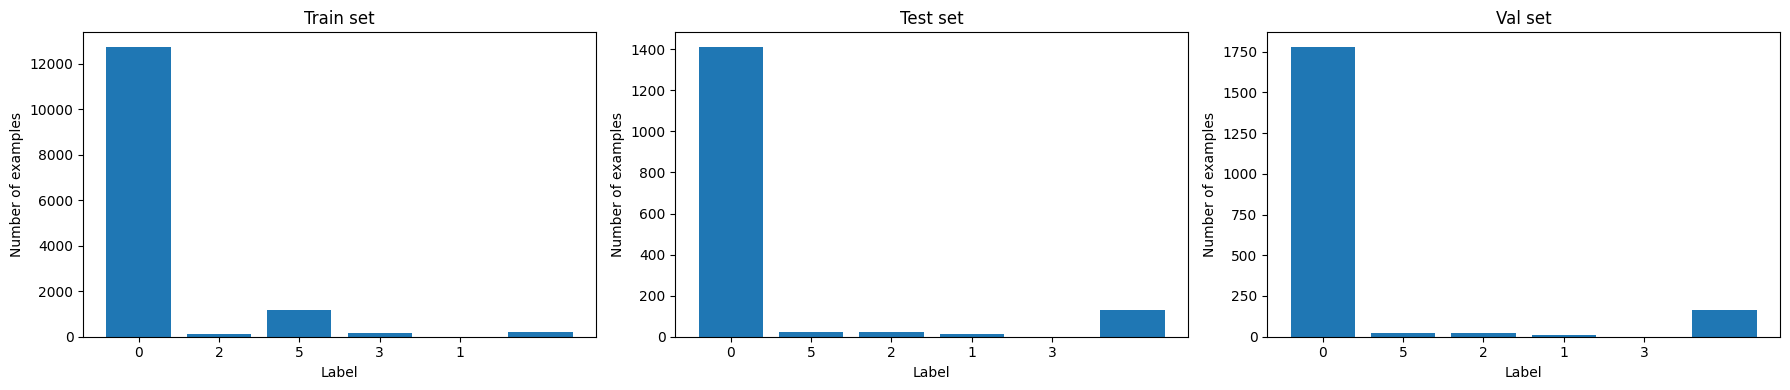

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting the distribution of labels in Train, Test, and Validation datasets
fig = plt.figure(figsize=(18, 4))
titles = ['Train set', 'Test set', 'Val set']

for i, dataf in enumerate([df_train, df_test, df_val]):
    ax = fig.add_subplot(1, 3, i+1)
    Y, labels = pd.factorize(dataf['label'])  # Ensure 'label' column is used
    ax.bar(labels, height=pd.Series(Y).value_counts())  # Bar plot for label count
    ax.set_xticks(ticks=range(len(labels)))  # Position the x-ticks
    ax.set_xticklabels(labels, fontsize=10)  # Set x-tick labels with font size
    ax.set_xlabel('Label')  # X-axis label
    ax.set_ylabel('Number of examples')  # Y-axis label
    ax.set_title(titles[i])  # Title for each plot

# Show the plots
plt.tight_layout()
plt.show()


In [34]:
# Number of samples in Train, Test, and Validation datasets
train_samples = len(df_train)
test_samples = len(df_test)
val_samples = len(df_val)

# Printing the number of samples
print(f"Number of samples in Train set: {train_samples}")
print(f"Number of samples in Test set: {test_samples}")
print(f"Number of samples in Validation set: {val_samples}")


Number of samples in Train set: 14409
Number of samples in Test set: 1601
Number of samples in Validation set: 1999


In [36]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle
from transformers import XLMRobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import SGD

In [37]:
import os

# Set parameters for fine-tuning
L_RATE = 3e-5  # Learning rate
MAX_LEN = 128  # Maximum sequence length (adjust according to your dataset)
NUM_EPOCHS = 3  # Number of epochs for fine-tuning
BATCH_SIZE = 32  # Batch size (can be adjusted based on GPU memory, using 64 if you have sufficient resources)
NUM_CORES = os.cpu_count()  # Number of CPU cores available for data processing
print(NUM_CORES)  # Print number of cores detected

# You can now use these parameters in your fine-tuning script


4


In [38]:
import torch
from transformers import XLMRobertaForSequenceClassification

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the XLM-RoBERTa model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-base',
    num_labels=6  # Set the number of labels to 6 (or the number of unique labels in your dataset)
)

# Move model to the device
model.to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [40]:
from torch.utils.data import Dataset
import torch
from transformers import XLMRobertaTokenizer

# Initialize the tokenizer
rTokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

class CompDataset(Dataset):

    def __init__(self, df):
        self.df_data = df

    def __getitem__(self, index):
        text = self.df_data.loc[index, 'cleaned_text']
        # Tokenization
        encoded_dict = rTokenizer.encode_plus(
                    text,
                    max_length = MAX_LEN,
                    padding='max_length',  # Use padding='max_length' instead of pad_to_max_length
                    truncation=True,  # Ensure that the text is truncated if it exceeds MAX_LEN
                    return_attention_mask=True,
                    return_tensors='pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        target = torch.tensor(self.df_data.loc[index, 'label'])

        sample = (padded_token_list, att_mask, target)
        return sample

    def __len__(self):
        return len(self.df_data)


In [41]:
train_dataset = CompDataset(df_cleaned_text_train)  # Pass your cleaned train DataFrame
test_dataset = CompDataset(df_cleaned_text_test)    # Pass your cleaned test DataFrame
validation_dataset = CompDataset(df_cleaned_text_val)  # Pass your validation DataFrame

In [42]:
print(len(test_dataset))
print(len(train_dataset))
print(len(validation_dataset))

1601
14409
1999


In [43]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def createBaseline(data, name):
    # Initialize the dataset and dataloader
    test_data = CompDataset(data)
    dataloader = torch.utils.data.DataLoader(test_data,
                      batch_size=BATCH_SIZE,
                      shuffle=False,  # No need to shuffle in the validation or test set
                      num_workers=NUM_CORES)

    # Set model to evaluation mode and disable gradient computation
    model.eval()
    torch.set_grad_enabled(False)

    # Initialize lists to store the predictions and true labels
    targets_list = []
    all_preds = []

    # Loop over the dataloader to get batches
    for j, batch in enumerate(dataloader):
        # Move the batch tensors to the device
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Get model predictions
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        preds = outputs[1]  # Get the logits

        # Convert predictions to numpy arrays and store them
        val_preds = preds.detach().cpu().numpy()
        targets_np = b_labels.to('cpu').numpy()
        targets_list.extend(targets_np)

        # Accumulate predictions
        all_preds.append(val_preds)

    # Convert the list of predictions into a single array
    stacked_val_preds = np.vstack(all_preds)

    # Calculate the predicted labels by taking argmax of logits
    y_true = np.array(targets_list)
    y_pred = np.argmax(stacked_val_preds, axis=1)

    # Compute accuracy and F1 score
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')  # Adding average='weighted' for handling class imbalance

    # Print results
    print(f"{name} test acc: {acc:.4f}")
    print(f"{name} test F1: {f1:.4f}")


In [45]:
createBaseline(df_cleaned_text_test, "malayalam")

malayalam test acc: 0.0006
malayalam test F1: 0.0004


In [46]:
import random
import gc

In [47]:
print(model.parameters())

<generator object Module.parameters at 0x79cba444d460>


In [48]:
optimizer = AdamW(model.parameters(),
              lr = L_RATE,
              eps = 1e-8
            )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [49]:
train_data = CompDataset(df_cleaned_text_train)
val_data = CompDataset(df_cleaned_text_val)

In [50]:
train_dataloader = torch.utils.data.DataLoader(train_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=NUM_CORES)
val_dataloader = torch.utils.data.DataLoader(val_data,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    num_workers=NUM_CORES)

In [51]:
gc.collect()

90

In [52]:
import torch
import random
import numpy as np
import gc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

seed_val = 101

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []

# Define your number of epochs
NUM_EPOCHS = 5

for epoch in range(0, NUM_EPOCHS):

    print("\n======== Epoch {:} / {:} ========".format(epoch + 1, NUM_EPOCHS))

    stacked_val_labels = []
    targets_list = []

    # Training Phase
    print('Training...')
    model.train()
    torch.set_grad_enabled(True)
    total_train_loss = 0
    gc.collect()

    for i, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
        optimizer.step()  # Update model weights
        gc.collect()

    print('Train loss:', total_train_loss)

    gc.collect()

    # Validation Phase
    print('\nValidation...')
    model.eval()
    torch.set_grad_enabled(False)
    total_val_loss = 0
    for j, batch in enumerate(val_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]
        total_val_loss += loss.item()
        preds = outputs[1]
        val_preds = preds.detach().cpu().numpy()
        targets_np = b_labels.to('cpu').numpy()
        targets_list.extend(targets_np)
        if j == 0:
            stacked_val_preds = val_preds
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
        gc.collect()

    y_true = targets_list
    y_pred = np.argmax(stacked_val_preds, axis=1)
    val_acc = accuracy_score(y_true, y_pred)
    val_precision = precision_score(y_true, y_pred, average='weighted')
    val_recall = recall_score(y_true, y_pred, average='weighted')
    val_f1 = f1_score(y_true, y_pred, average='weighted')

    print('Val loss:', total_val_loss)
    print('Val acc:', val_acc)
    print('Val precision:', val_precision)
    print('Val recall:', val_recall)
    print('Val f1:', val_f1)

    gc.collect()

    # Save model weights after each epoch
    torch.save(model.state_dict(), 'model.pt')

    gc.collect()



======== Epoch 1 / 5 ========
Training...
Train loss: 167.6464485116303

Validation...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val loss: 16.44484517723322
Val acc: 0.9389694847423712
Val precision: 0.9110150740304468
Val recall: 0.9389694847423712
Val f1: 0.924439627573649

======== Epoch 2 / 5 ========
Training...
Train loss: 128.54193569906056

Validation...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val loss: 15.353804010897875
Val acc: 0.9474737368684342
Val precision: 0.9206472965967161
Val recall: 0.9474737368684342
Val f1: 0.9338609539077746

======== Epoch 3 / 5 ========
Training...
Train loss: 117.22193340398371

Validation...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val loss: 15.235812906175852
Val acc: 0.9504752376188094
Val precision: 0.9229336221391852
Val recall: 0.9504752376188094
Val f1: 0.9362877136439284

======== Epoch 4 / 5 ========
Training...
Train loss: 102.13272504787892

Validation...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val loss: 18.5659426022321
Val acc: 0.9299649824912456
Val precision: 0.9141153898438702
Val recall: 0.9299649824912456
Val f1: 0.9195749357270332

======== Epoch 5 / 5 ========
Training...
Train loss: 92.15634568408132

Validation...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Val loss: 15.18838531523943
Val acc: 0.950975487743872
Val precision: 0.9242636684883796
Val recall: 0.950975487743872
Val f1: 0.9373943508466737
